# Importing Packages

In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For data preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

# For LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import History

# Dataset

In [2]:
def create_lstm_datasets(
    df: pd.DataFrame, 
    history: int=60, 
    train_test_split_date: str="2021-10-29") -> list:
  """
  Creating train and test datasets for LSTM models

  INPUTS:
    :df (pd.DataFrame): Input data for each ticker
    :history (int): Default to 60. 
                    Denotes the sequence length to be given to an LSTM model.
    :train_test_split_date (str): Default to 2021-10-29.
                                  Denotes the point in time after which the 
                                  predictions are to be made.

  OUTPUTSL
    :(list): X_train, X_test, y_train, y_test.
  """
  # Creating moving window and appending values to X and y lists
  X, y = [], []
  for idx in range(history+1, df.shape[0]):
    X.append(df.iloc[idx-history:idx-1, :])
    y.append(df.loc[df.index[idx], "Adj_Close"])
  
  # Typecasting lists are arrays
  X = np.array(X)
  y = np.array(y)

  # Splitting arrays into train and test sets
  train_test_split_idx = list(df.index).index(train_test_split_date)-(history-1)
  X_train = X[:train_test_split_idx, :, :]
  X_test = X[train_test_split_idx:, :, :]
  y_train = y[:train_test_split_idx]
  y_test = y[train_test_split_idx:]
  
  # Returning the results
  return X_train, X_test, y_train, y_test

# LSTM Model

In [3]:
def create_lstm_model(n_seq: int, n_features: int) -> Sequential:
  """
  Creating the model architecture used for each LSTM Model.

  INPUTS:
    :n_seq (int): Number of points in each sequence of the LSTM input.
    :n_features (int): Number of features for each point in a sequence of LSTM input.
  
  OUTPUTS:
    :(Sequential): The model architecture.
  """
  model = Sequential()
  model.add(LSTM(units = 50, 
                 return_sequences = True, 
                 input_shape = (n_seq, n_features))
  )
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(LSTM(units = 50))
  model.add(Dense(units = 10))
  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

In [4]:
def fit_lstm_model(
    model: Sequential,
    X_train: np.array, 
    y_train: np.array, 
    X_test: np.array, 
    y_test: np.array, 
    best_model_name: str) -> list:
  """
  Fits the LSTM model, implements early stopping and stores the best model.

  INPUTS:
    :model (Sequential): Compiled LSTM Model
    :X_train (np.array): Train dataset
    :y_train (np.array): Train targets
    :X_test (np.array): Test dataset
    :y_test (np.array): Test dataset 
    :best_model_name (str): Best model will be saved with this name

  OUTPUTS:
    :(list): List of History object, and trained model.
  """
  # Early stopping 
  # Stop training if the validation loss does not improve for 20 epochs
  es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=0, 
    patience=20
  )
  
  # Model checkpoints
  # Save the best model yet
  mc = ModelCheckpoint(
    best_model_name + '.h5', 
    monitor='val_loss', 
    mode='min', 
    verbose=0, 
    save_best_only=True
  )

  # Fitting the model and storing the result in history.
  history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=100, 
    verbose=1, 
    callbacks=[es, mc]
  )

  # Returning History object, and trained model.
  return history, model

In [5]:
def evaluate_model(
    model: Sequential, 
    X_train: np.array, 
    y_train: np.array, 
    X_test: np.array, 
    y_test: np.array, 
    history: History,  
    ticker: str):
  """
  Prints out some summary statistics and graphs about the model.

  INPUTS:
    :model (Sequential): Compiled LSTM Model
    :X_train (np.array): Train dataset
    :y_train (np.array): Train targets
    :X_test (np.array): Test dataset
    :y_test (np.array): Test dataset 
    :history (History): Tensorflow History object. Useful for displaying loss curves
    :model (Sequential): Trained Model
    :ticker (str): Company Name
  
  OUTPUTS:
    :(None): No output for this function.
  """
  # Getting train and test predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)
  # Getting train and test RMSE
  train_rmse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=train_preds))
  test_rmse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=test_preds))
  # Printing train and test RMSE
  print(f"Train RMSE: {round(train_rmse, 4)}")
  print(f"Test RMSE: {round(test_rmse, 4)}")
  print("-"*30, end="\n\n")

  # Plotting train and test loss curves
  fig, ax = plt.subplots(1, 3, figsize = (20, 5))
  
  ax[0].plot(y_train, label="Train values")
  ax[0].plot(train_preds, label="Train predictions")
  ax[0].set_xlabel("Time", size=12)
  ax[0].set_ylabel("Stock Price", size=12)
  ax[0].set_ylim([y_train.min()-10, y_train.max()+10])
  ax[0].set_title(ticker + "Train values vs predictions", size=15)
  ax[0].grid()
  ax[0].legend()

  ax[1].plot(y_test, label="Test values")
  ax[1].plot(test_preds, label="Test predictions")
  ax[1].set_xlabel("Time", size=12)
  ax[1].set_ylabel("Stock Price", size=12)
  ax[1].set_ylim([y_train.min()-10, y_test.max()+10])
  ax[1].set_title(ticker + "Test values vs predictions", size=15)
  ax[1].grid()
  ax[1].legend()

  ax[2].plot(history.history["loss"], label="train loss")
  ax[2].plot(history.history["val_loss"], label="test loss")
  ax[2].set_xlabel("Epochs", size=12)
  ax[2].set_ylabel("Loss", size=12)
  ax[2].set_title(ticker + "Learning Curves", size=15)
  ax[2].grid()
  ax[2].legend()
  
  plt.show()

# Fitting Models for all companies

## Facebook

Dataset

In [6]:
df = pd.read_csv("/content/fb_sentiment_df.csv")
df.set_index("Date", inplace=True)

X_train, X_test, y_train, y_test = create_lstm_datasets(df)

Model architecture

In [7]:
fb_model = create_lstm_model(
    n_seq = X_train.shape[1], 
    n_features = X_train.shape[2]
  )

In [8]:
fb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 50)            13600     
                                                                 
 lstm_1 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74,721
Trainable params: 74,721
Non-traina

Model training

In [9]:
fb_history, fb_model = fit_lstm_model(
    model = fb_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    best_model_name = "fb")

Epoch 1/100
54/54 [==============================] - 13s 95ms/step - loss: 34859.4805 - val_loss: 102392.4219
Epoch 2/100
54/54 [==============================] - 3s 63ms/step - loss: 29009.8809 - val_loss: 90828.7344
Epoch 3/100
54/54 [==============================] - 3s 62ms/step - loss: 23090.6758 - val_loss: 77779.9141
Epoch 4/100
54/54 [==============================] - 3s 61ms/step - loss: 17227.2246 - val_loss: 64355.2109
Epoch 5/100
54/54 [==============================] - 3s 62ms/step - loss: 12232.9639 - val_loss: 51989.7188
Epoch 6/100
54/54 [==============================] - 3s 62ms/step - loss: 8656.6416 - val_loss: 41831.2812
Epoch 7/100
54/54 [==============================] - 3s 62ms/step - loss: 6554.5361 - val_loss: 34525.8359
Epoch 8/100
54/54 [==============================] - 3s 62ms/step - loss: 5550.1938 - val_loss: 29860.8555
Epoch 9/100
54/54 [==============================] - 3s 62ms/step - loss: 5183.7896 - val_loss: 26926.3164
Epoch 10/100
54/54 [==========

Evaluation

Train RMSE: 7.9301
Test RMSE: 14.649
------------------------------



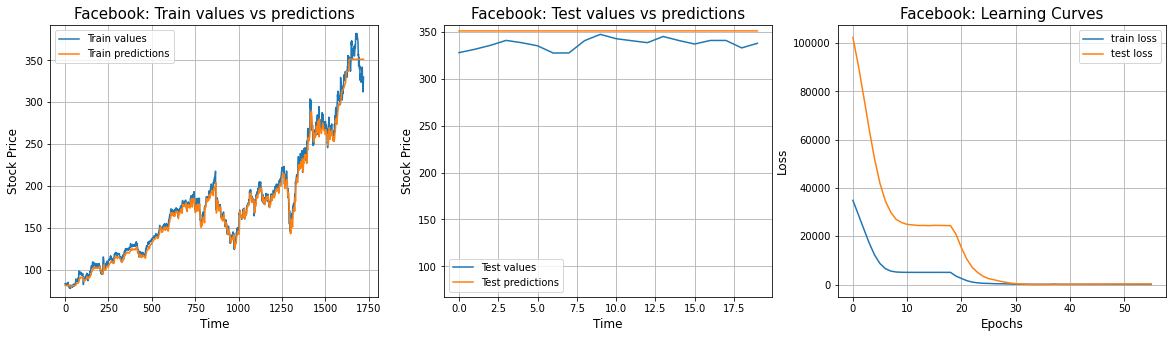

In [11]:
evaluate_model(
    model = fb_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test,
    history = fb_history,  
    ticker = "Facebook: ")

## Apple

Dataset

In [6]:
df = pd.read_csv("/content/aapl_sentiment_df.csv")
df.set_index("Date", inplace=True)

X_train, X_test, y_train, y_test = create_lstm_datasets(df)

Model architecture

In [7]:
aapl_model = create_lstm_model(
    n_seq = X_train.shape[1], 
    n_features = X_train.shape[2]
  )

In [8]:
aapl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 50)            13600     
                                                                 
 lstm_1 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74,721
Trainable params: 74,721
Non-traina

Model training

In [9]:
aapl_history, aapl_model = fit_lstm_model(
    model = aapl_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    best_model_name = "aapl")

Epoch 1/100
54/54 [==============================] - 13s 97ms/step - loss: 33775.6055 - val_loss: 97871.2734
Epoch 2/100
54/54 [==============================] - 3s 62ms/step - loss: 26045.4062 - val_loss: 83380.0078
Epoch 3/100
54/54 [==============================] - 3s 63ms/step - loss: 19474.2715 - val_loss: 69152.7031
Epoch 4/100
54/54 [==============================] - 3s 62ms/step - loss: 13829.1260 - val_loss: 55826.8125
Epoch 5/100
54/54 [==============================] - 3s 62ms/step - loss: 9614.5322 - val_loss: 44597.3672
Epoch 6/100
54/54 [==============================] - 3s 62ms/step - loss: 7013.0615 - val_loss: 36120.9102
Epoch 7/100
54/54 [==============================] - 3s 62ms/step - loss: 5723.5332 - val_loss: 30614.4902
Epoch 8/100
54/54 [==============================] - 3s 63ms/step - loss: 5223.8257 - val_loss: 27523.4160
Epoch 9/100
54/54 [==============================] - 3s 63ms/step - loss: 5075.2954 - val_loss: 25798.5625
Epoch 10/100
54/54 [============

Evaluation

Train RMSE: 6.7919
Test RMSE: 32.449
------------------------------



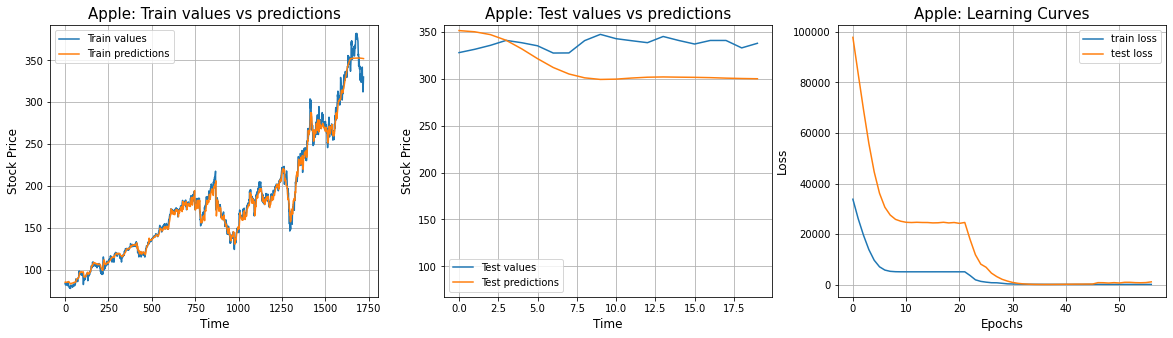

In [10]:
evaluate_model(
    model = aapl_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test,
    history = aapl_history,  
    ticker = "Apple: ")

## Amazon

Dataset

In [6]:
df = pd.read_csv("/content/amzn_sentiment_df.csv")
df.set_index("Date", inplace=True)

X_train, X_test, y_train, y_test = create_lstm_datasets(df)

Model architecture

In [7]:
amzn_model = create_lstm_model(
    n_seq = X_train.shape[1], 
    n_features = X_train.shape[2]
  )

In [8]:
amzn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 50)            13600     
                                                                 
 lstm_1 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74,721
Trainable params: 74,721
Non-traina

Model training

In [9]:
amzn_history, amzn_model = fit_lstm_model(
    model = amzn_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    best_model_name = "amzn")

Epoch 1/100
54/54 [==============================] - 13s 97ms/step - loss: 34097.8086 - val_loss: 99493.8359
Epoch 2/100
54/54 [==============================] - 3s 62ms/step - loss: 27149.4590 - val_loss: 86280.7891
Epoch 3/100
54/54 [==============================] - 3s 63ms/step - loss: 20844.2324 - val_loss: 72510.4062
Epoch 4/100
54/54 [==============================] - 3s 62ms/step - loss: 15137.6035 - val_loss: 59091.6641
Epoch 5/100
54/54 [==============================] - 3s 63ms/step - loss: 10608.4629 - val_loss: 47551.0703
Epoch 6/100
54/54 [==============================] - 3s 63ms/step - loss: 7612.7544 - val_loss: 38567.9844
Epoch 7/100
54/54 [==============================] - 3s 63ms/step - loss: 6009.1592 - val_loss: 32095.6250
Epoch 8/100
54/54 [==============================] - 3s 63ms/step - loss: 5331.8164 - val_loss: 28255.0977
Epoch 9/100
54/54 [==============================] - 3s 62ms/step - loss: 5105.8359 - val_loss: 26200.2871
Epoch 10/100
54/54 [===========

Evaluation

Train RMSE: 7.4377
Test RMSE: 14.2415
------------------------------



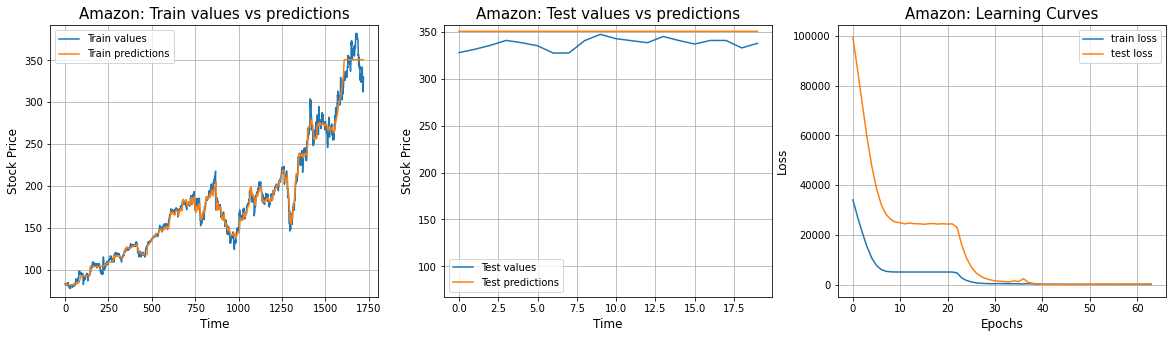

In [10]:
evaluate_model(
    model = amzn_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test,
    history = amzn_history,  
    ticker = "Amazon: ")

## Netflix

Dataset

In [6]:
df = pd.read_csv("/content/nflx_sentiment_df.csv")
df.set_index("Date", inplace=True)

X_train, X_test, y_train, y_test = create_lstm_datasets(df)

Model architecture

In [7]:
nflx_model = create_lstm_model(
    n_seq = X_train.shape[1], 
    n_features = X_train.shape[2]
  )

In [8]:
nflx_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 50)            13600     
                                                                 
 lstm_1 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74,721
Trainable params: 74,721
Non-traina

Model training

In [9]:
nflx_history, nflx_model = fit_lstm_model(
    model = nflx_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    best_model_name = "nflx")

Epoch 1/100
54/54 [==============================] - 13s 94ms/step - loss: 33589.4766 - val_loss: 97113.5703
Epoch 2/100
54/54 [==============================] - 3s 61ms/step - loss: 25670.2676 - val_loss: 82551.2656
Epoch 3/100
54/54 [==============================] - 3s 62ms/step - loss: 19109.6953 - val_loss: 68276.1406
Epoch 4/100
54/54 [==============================] - 3s 63ms/step - loss: 13508.8301 - val_loss: 54991.4805
Epoch 5/100
54/54 [==============================] - 3s 61ms/step - loss: 9357.1660 - val_loss: 43913.9766
Epoch 6/100
54/54 [==============================] - 3s 61ms/step - loss: 6838.6968 - val_loss: 35587.5703
Epoch 7/100
54/54 [==============================] - 3s 61ms/step - loss: 5635.1768 - val_loss: 30222.3867
Epoch 8/100
54/54 [==============================] - 3s 61ms/step - loss: 5187.4580 - val_loss: 27178.7344
Epoch 9/100
54/54 [==============================] - 3s 61ms/step - loss: 5066.7773 - val_loss: 25546.1270
Epoch 10/100
54/54 [============

Evaluation

Train RMSE: 7.0762
Test RMSE: 6.6664
------------------------------



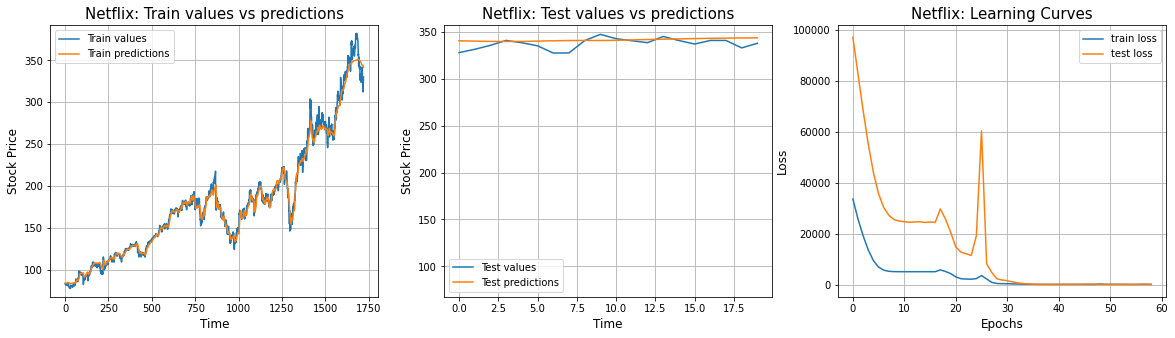

In [10]:
evaluate_model(
    model = nflx_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test,
    history = nflx_history,  
    ticker = "Netflix: ")

## Google

Dataset

In [6]:
df = pd.read_csv("/content/goog_sentiment_df.csv")
df.set_index("Date", inplace=True)

X_train, X_test, y_train, y_test = create_lstm_datasets(df)

Model architecture

In [7]:
goog_model = create_lstm_model(
    n_seq = X_train.shape[1], 
    n_features = X_train.shape[2]
  )

In [8]:
goog_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 59, 50)            13600     
                                                                 
 lstm_1 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 59, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 74,721
Trainable params: 74,721
Non-traina

Model training

In [9]:
goog_history, goog_model = fit_lstm_model(
    model = goog_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test, 
    best_model_name = "goog")

Epoch 1/100
54/54 [==============================] - 12s 94ms/step - loss: 34873.0938 - val_loss: 102127.2344
Epoch 2/100
54/54 [==============================] - 3s 62ms/step - loss: 28774.1680 - val_loss: 90110.2656
Epoch 3/100
54/54 [==============================] - 3s 62ms/step - loss: 22723.8242 - val_loss: 76816.6641
Epoch 4/100
54/54 [==============================] - 3s 62ms/step - loss: 16809.6230 - val_loss: 63208.7383
Epoch 5/100
54/54 [==============================] - 3s 62ms/step - loss: 11824.0439 - val_loss: 50818.7500
Epoch 6/100
54/54 [==============================] - 3s 61ms/step - loss: 8324.1299 - val_loss: 40719.3750
Epoch 7/100
54/54 [==============================] - 3s 63ms/step - loss: 6342.5181 - val_loss: 33578.8984
Epoch 8/100
54/54 [==============================] - 3s 61ms/step - loss: 5452.0195 - val_loss: 29179.5098
Epoch 9/100
54/54 [==============================] - 3s 62ms/step - loss: 5143.9790 - val_loss: 26648.6094
Epoch 10/100
54/54 [==========

Evaluation

Train RMSE: 6.7957
Test RMSE: 14.8617
------------------------------



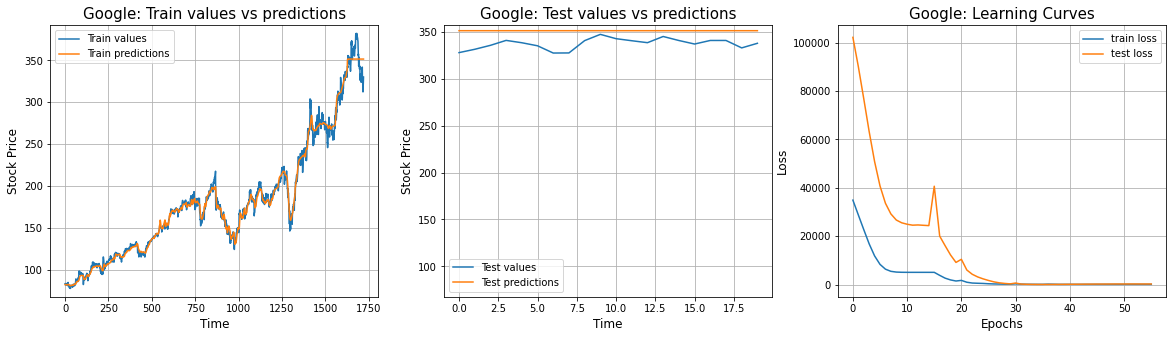

In [10]:
evaluate_model(
    model = goog_model,
    X_train = X_train, 
    y_train = y_train, 
    X_test = X_test, 
    y_test = y_test,
    history = goog_history,  
    ticker = "Google: ")